# Proyecto: Preparación y Transformación de Datos para Detección de Noticias Falsas



## 1. Importación de Librerías y Configuración

Se importan las librerías esenciales para la manipulación de datos, visualización y procesamiento de textos. Además, se configuran las stopwords de NLTK y el stemmer para español.

In [3]:
import pandas as pd             # Manipulación de datos
import numpy as np              # Operaciones numéricas
import matplotlib.pyplot as plt # Visualizaciones
import seaborn as sns           # Gráficos estadísticos
import re                       # Expresiones regulares
import nltk                     # Procesamiento de lenguaje natural

# Descargar stopwords (solo la primera vez)
nltk.download('stopwords')
from nltk.corpus import stopwords

# SnowballStemmer para español
from nltk.stem.snowball import SnowballStemmer

# Configuración de stopwords y stemmer
stop_words = set(stopwords.words('spanish'))
stemmer = SnowballStemmer('spanish')

# Configurar estilo para gráficos
sns.set(style='whitegrid')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/jcedielb/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## 2. Funciones para Limpieza y Procesamiento de Textos

Se definen dos funciones fundamentales:

- **clean_text(text)**: Convierte el texto a minúsculas, elimina URLs, elimina caracteres no alfabéticos (dejando acentos y ñ) y quita espacios extra.
- **process_text(text)**: Utiliza `clean_text` para limpiar el texto, lo tokeniza (por separación de espacios), elimina stopwords y aplica stemming para obtener la raíz de cada palabra.

Estas funciones permiten transformar el texto de forma que se eliminen prefijos y sufijos innecesarios, dejando las palabras en su forma base.

In [4]:
def clean_text(text):
    """
    Limpia el texto realizando:
      - Conversión a minúsculas
      - Eliminación de URLs
      - Eliminación de caracteres que no sean letras (se conservan acentos y ñ)
      - Eliminación de espacios extra
    """
    if pd.isnull(text):
        return ""
    text = text.lower()
    text = re.sub(r'http\S+', '', text)  # Elimina URLs
    text = re.sub(r'[^a-záéíóúñ\s]', '', text)  # Conserva solo letras y espacios
    text = re.sub(r'\s+', ' ', text).strip()  # Elimina espacios extra
    return text

def process_text(text):
    """
    Procesa el texto aplicando:
      - Limpieza básica (clean_text)
      - Tokenización (separa palabras)
      - Eliminación de stopwords
      - Aplicación de stemming para obtener la raíz de cada palabra
    """
    if pd.isnull(text):
        return ""
    text = clean_text(text)
    words = text.split()
    # Aplicar stemming y eliminar stopwords
    words = [stemmer.stem(word) for word in words if word not in stop_words]
    return " ".join(words)

## 3. Gestión y Análisis de Datos

### 3.1 Descarga y Exploración del Conjunto de Datos

Se carga el dataset (se asume que está en `fake_news_spanish.csv`) y se exploran sus dimensiones, primeras filas, información general y la cantidad de valores nulos. También se identifican las fuentes de datos (si la columna existe).

In [6]:
# Ajusta la ruta y el separador según el formato del CSV
ruta = 'fake_news_spanish.csv'
df = pd.read_csv(ruta, sep=';', encoding='utf-8')

print('Dimensiones del dataset:', df.shape)
print('Primeras 5 filas:')
print(df.head())

print('Información del dataset:')
print(df.info())

print('Valores nulos por columna:')
print(df.isnull().sum())

# Si existe la columna 'source', mostrar las fuentes disponibles
if 'source' in df.columns:
    print('Fuentes de datos:', df['source'].unique())
else:
    print('No se encontró la columna de fuentes de datos.')

Dimensiones del dataset: (57063, 5)
Primeras 5 filas:
   ID  Label                                             Titulo  \
0  ID      1  'The Guardian' va con Sánchez: 'Europa necesit...   
1  ID      0  REVELAN QUE EL GOBIERNO NEGOCIO LA LIBERACIÓN ...   
2  ID      1  El 'Ahora o nunca' de Joan Fuster sobre el est...   
3  ID      1  Iglesias alienta a Yolanda Díaz, ERC y EH Bild...   
4  ID      0  Puigdemont: 'No sería ninguna tragedia una rep...   

                                         Descripcion       Fecha  
0  El diario británico publicó este pasado jueves...  02/06/2023  
1  REVELAN QUE EL GOBIERNO NEGOCIO LA LIBERACIÓN ...  01/10/2023  
2  El valencianismo convoca en Castelló su fiesta...  25/04/2022  
3  En política, igual que hay que negociar con lo...  03/01/2022  
4  En una entrevista en El Punt Avui, el líder de...  09/03/2018  
Información del dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 57063 entries, 0 to 57062
Data columns (total 5 columns):
 #   Col

### 3.2 Análisis Exploratorio

Se realizan estadísticas descriptivas y se generan gráficos y tablas para identificar valores atípicos y datos faltantes. Además, se distinguen las variables numéricas (por ejemplo, la longitud del contenido) de las categóricas (por ejemplo, Titulo, Descripcion, label, source, etc.).

Estadísticas descriptivas:
              Label
count  57063.000000
mean       0.581077
std        0.493387
min        0.000000
25%        0.000000
50%        1.000000
75%        1.000000
max        1.000000
Variables categóricas:
['ID', 'Titulo', 'Descripcion', 'Fecha']
Valores faltantes por columna:
Titulo    16
dtype: int64


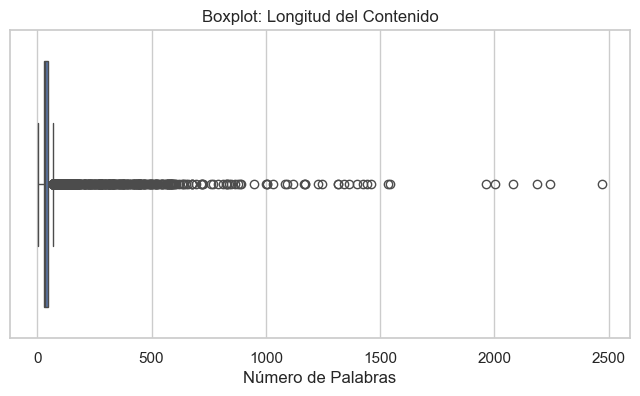

In [7]:
# Estadísticas descriptivas para variables numéricas
print('Estadísticas descriptivas:')
print(df.describe())

# Mostrar las variables de tipo objeto (categóricas)
print('Variables categóricas:')
print(df.select_dtypes(include=['object']).columns.tolist())

# Valores faltantes en columnas
missing = df.isnull().sum()
print('Valores faltantes por columna:')
print(missing[missing > 0])

# Ejemplo: Análisis de valores atípicos usando un boxplot de la longitud del contenido
if 'Descripcion' in df.columns:
    df['content_length'] = df['Descripcion'].apply(lambda x: len(x.split()))
    plt.figure(figsize=(8,4))
    sns.boxplot(x=df['content_length'])
    plt.title('Boxplot: Longitud del Contenido')
    plt.xlabel('Número de Palabras')
    plt.show()

## 4. Transformación de Datos

En esta sección se aplican las siguientes transformaciones:

- **Eliminación de duplicados:** Se eliminan registros repetidos.
- **Limpieza y normalización de textos:** Se procesan las columnas 'Titulo' y 'Descripcion' aplicando las funciones definidas, lo que incluye limpieza, tokenización, eliminación de stopwords y stemming.
- **Normalización adicional (si fuese necesario):** Se pueden aplicar transformaciones numéricas (por ejemplo, escalado) a variables numéricas.

Cada transformación se justifica para mejorar la calidad del modelo y evitar ruido en el análisis.

In [8]:
# Eliminar duplicados
df = df.drop_duplicates()
print('Dimensiones tras eliminar duplicados:', df.shape)

# Rellenar valores nulos en las columnas de texto
df['Titulo'] = df['Titulo'].fillna('')
df['Descripcion'] = df['Descripcion'].fillna('')

Dimensiones tras eliminar duplicados: (56618, 6)


### 4.1 Limpieza y Normalización de Textos

Se procesan las columnas de texto utilizando las funciones definidas. Se generan dos nuevas columnas: `title_clean` y `content_clean`.

In [9]:
# Procesar la columna 'Titulo'
df['title_clean'] = df['Titulo'].apply(process_text)

# Procesar la columna 'Descripcion'
df['content_clean'] = df['Descripcion'].apply(process_text)

print('Ejemplo de Titulo original y procesado:')
print(df[['Titulo', 'title_clean']].head())

print('Ejemplo de Descripcion original y procesado:')
print(df[['Descripcion', 'content_clean']].head())

Ejemplo de Titulo original y procesado:
                                              Titulo  \
0  'The Guardian' va con Sánchez: 'Europa necesit...   
1  REVELAN QUE EL GOBIERNO NEGOCIO LA LIBERACIÓN ...   
2  El 'Ahora o nunca' de Joan Fuster sobre el est...   
3  Iglesias alienta a Yolanda Díaz, ERC y EH Bild...   
4  Puigdemont: 'No sería ninguna tragedia una rep...   

                                         title_clean  
0  the guardi va sanchez europ necesit apuest de ...  
1  revel gobiern negoci liber mirel cambi otorg p...  
2   ahor nunc joan fust estatut valencian cumpl años  
3  iglesi alient yoland diaz erc eh bildu negoci ...  
4      puigdemont ningun tragedi repeticion eleccion  
Ejemplo de Descripcion original y procesado:
                                         Descripcion  \
0  El diario británico publicó este pasado jueves...   
1  REVELAN QUE EL GOBIERNO NEGOCIO LA LIBERACIÓN ...   
2  El valencianismo convoca en Castelló su fiesta...   
3  En política, igual qu

### 4.2 Evidencias y Gráficos de Transformación

Se generan gráficos para evidenciar la transformación realizada, por ejemplo, la distribución de la longitud del contenido (basada en la columna 'Descripcion').

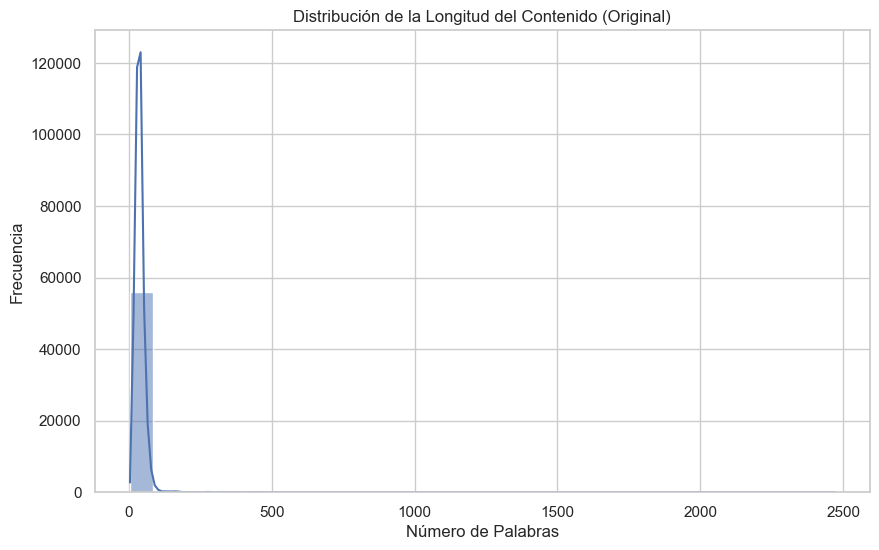

In [10]:
# Calcular la longitud del contenido (número de palabras) en la columna original
df['content_length'] = df['Descripcion'].apply(lambda x: len(x.split()))

plt.figure(figsize=(10,6))
sns.histplot(df['content_length'], bins=30, kde=True)
plt.title('Distribución de la Longitud del Contenido (Original)')
plt.xlabel('Número de Palabras')
plt.ylabel('Frecuencia')
plt.show()

## 5. Entrega de Datos Preparados

Una vez realizadas las transformaciones y el análisis, se guarda el conjunto de datos preprocesado para su uso en modelos posteriores. Además, se documenta brevemente el proceso de transformación y se justifica la calidad de los datos resultantes.

In [11]:
# Guardar el dataset preprocesado en un nuevo archivo CSV
df.to_csv('fake_news_spanish_preparado.csv', index=False, encoding='utf-8')
print("El dataset preprocesado se ha guardado como 'fake_news_spanish_preparado.csv'.")

El dataset preprocesado se ha guardado como 'fake_news_spanish_preparado.csv'.


## 6. División en Conjuntos de Entrenamiento y Prueba

Se divide el conjunto de datos preprocesado en un 80% para entrenamiento y un 20% para prueba. Esto se realizará usando `train_test_split` de scikit-learn.

In [12]:
from sklearn.model_selection import train_test_split

# Dividir el dataset en 80% entrenamiento y 20% prueba
train, test = train_test_split(df, test_size=0.2, random_state=33)

print('Dimensiones del conjunto de entrenamiento:', train.shape)
print('Dimensiones del conjunto de prueba:', test.shape)

# Mostrar una muestra del conjunto de entrenamiento
train.head()

Dimensiones del conjunto de entrenamiento: (45294, 8)
Dimensiones del conjunto de prueba: (11324, 8)


,ID,Label,Titulo,Descripcion,Fecha,content_length,title_clean,content_clean
51430,ID,1,Escrivá reconoce que creó un 'ruido innecesari...,"El ministro de Seguridad Social, que ha presen...",07/07/2021,43,escriv reconoc cre ruid innecesari palabr reco...,ministr segur social present congres prim acue...
53656,ID,1,El estado de alarma deja más de 1.400 detenido...,"Por comunidades autónomas, y con datos de medi...",20/06/2020,41,alarm dej deten sancion ley mordaz bas denunci,comun autonom dat medi juni andaluc acap mayor...
3891,ID,0,Absuelto el interventor general que emitió el ...,La Audiencia razona que Manuel Jéssica Albiach...,19/11/2019,43,absuelt interventor general emit inform alert ...,audienci razon manuel jessic albiach intervent...
15855,ID,1,El Congreso aprueba la ley para equiparar los ...,"ERC, Bildu, PNV y PDeCat no han votado a favor...",13/11/2018,48,congres aprueb ley equipar sueld diferent fuer...,erc bildu pnv pdecat vot favor ilp present jus...
4772,ID,1,El autor de la carta con la navaja a la minist...,"El remitente, de apellido Escudero Arias-Dávil...",27/04/2021,59,autor cart navaj ministr marot emparent diput ...,remitent apell escuder ariasdavil años residen...
